### Якубов В.Ю. ДЗ_2 МАДМО
 - реализовать и отладить файнтюнинг крупной модели
 - Реализовать собственную модель
 - Реализовать дистилляцию из крупной модели в небольшую предобученную
 - Использовать Прунинг

### Импорт необходимых библиотек

In [4]:
import os # Для работы с системой
import shutil # Для копирования файлов
from tqdm import tqdm # Для отслеживания прогресса различных задач
import pandas as pd # Для считывания информации о датасете
from torch.optim.lr_scheduler import ReduceLROnPlateau # Для обучения нейронной сети
from torch.optim import Adam # Оптимизатор нейронной сети
from IPython.display import clear_output # Для отчистки графика во время обучения НС
from sklearn.metrics import classification_report # Для вывода финальных метрик
import matplotlib.pyplot as plt # Для визуализации
import numpy as np # Для математических операций
from sklearn.preprocessing import LabelEncoder # Для кодирования перемнных
from sklearn.model_selection import train_test_split # для создания тестовой выборки
import torchvision.models as models # Для импортирования моедлей pytorch
import torch # Для работы с глебоким обучением
from torch import nn #
from torch.utils.data import Dataset, DataLoader # Для удобного создания датасетов и лоадеров
from torchvision import transforms # Для аугументации
from PIL import Image # Для считывания изображений
from sklearn.utils import resample # Для сэмплирования

d:\mlp\machinelearning\venv\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\mlp\MachineLearning\venv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


### Поместим все файлы в одну папку

In [9]:
if 'merged_data' not in os.listdir():
    os.makedirs('merged_data')
for i in tqdm(os.listdir('cancer_dataset/HAM10000_images_part_1')):
    shutil.copyfile(f'cancer_dataset/HAM10000_images_part_1/{i}', f'merged_data/{i}')
for i in tqdm(os.listdir('cancer_dataset/HAM10000_images_part_2')):
    shutil.copyfile(f'cancer_dataset/HAM10000_images_part_2/{i}', f'merged_data/{i}')

100%|██████████| 5015/5015 [00:03<00:00, 1512.48it/s]


Считаем информацию о датасете

In [10]:
dataframe = pd.read_csv('cancer_dataset/HAM10000_metadata.csv')

In [11]:
dataframe.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


закодируем целевую переменную

In [12]:
le = LabelEncoder()
dataframe.dx = le.fit_transform(dataframe.dx)

Сделаем разделение на тест и трейн

In [13]:
data_train, data_test = train_test_split(dataframe, test_size=0.2)

Для обучения применим апсемплинг классов, экземпляров которых очень мало в датасете. Были применены разные подходы, апсемплинг показал себя лучше всего

In [14]:
maximum = data_train.groupby('dx').image_id.count().max()

In [15]:
maximum

5360

In [15]:
res = pd.DataFrame()
for i in data_train.dx.unique():
    res = res.append(resample(data_train[data_train.dx==i], n_samples=maximum))

C:\Users\Admin\AppData\Local\Temp\ipykernel_17612\2850963880.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(resample(data_train[data_train.dx==i], n_samples=maximum))
C:\Users\Admin\AppData\Local\Temp\ipykernel_17612\2850963880.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(resample(data_train[data_train.dx==i], n_samples=maximum))
C:\Users\Admin\AppData\Local\Temp\ipykernel_17612\2850963880.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(resample(data_train[data_train.dx==i], n_samples=maximum))
C:\Users\Admin\AppData\Local\Temp\ipykernel_17612\2850963880.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

In [16]:
res

,lesion_id,image_id,dx,dx_type,age,sex,localization
8958,HAM_0000922,ISIC_0031111,5,histo,55.0,male,upper extremity
5464,HAM_0003645,ISIC_0024390,5,follow_up,65.0,male,upper extremity
6449,HAM_0005765,ISIC_0028031,5,follow_up,45.0,male,lower extremity
4825,HAM_0002213,ISIC_0030222,5,follow_up,55.0,female,lower extremity
9463,HAM_0005263,ISIC_0033918,5,consensus,40.0,male,trunk
...,...,...,...,...,...,...,...
1105,HAM_0007526,ISIC_0030244,3,histo,50.0,male,lower extremity
1207,HAM_0006707,ISIC_0030870,3,consensus,45.0,female,lower extremity
1205,HAM_0007569,ISIC_0025373,3,consensus,35.0,female,lower extremity
1121,HAM_0007421,ISIC_0025302,3,histo,60.0,female,lower extremity


In [17]:
### Было бы полезно в случае, если бы не использовался апсемплинг, однако аугументация редковстречающихся классов с большей вероятностью не показала себя так хорошо
transform_probability = (1 - res.dx.value_counts()/len(res)) * 0.5
transform_probability_dict = transform_probability.to_dict()
transform_probability_dict

{5: 0.4285714285714286,
 1: 0.4285714285714286,
 4: 0.4285714285714286,
 6: 0.4285714285714286,
 2: 0.4285714285714286,
 0: 0.4285714285714286,
 3: 0.4285714285714286}

В X лежат названия изображений, в y таргет

In [19]:
X_train, X_test, y_train, y_test = list(res.image_id), list(data_test.image_id), list(res.dx), list(data_test.dx)

Напишем кастомный датасет

In [20]:
class CustomDataset(Dataset):
    def __init__(self, images_paths, image_labels, transform_probs, train=True):
        self.paths = images_paths
        self.labels = image_labels
        self.transform_probs = transform_probs
        self.train = train
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, item):
        image_name = self.paths[item]
        image_label = self.labels[item]
        image = Image.open(f'D:\mlp\MachineLearning\MADMO_2nd_homework\merged_data\{image_name}.jpg')
        transform_probability = self.transform_probs[image_label] if self.train else 0
        transformation = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((32, 32)),
                transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225)),
                transforms.RandomHorizontalFlip(p=transform_probability),
                transforms.RandomVerticalFlip(p=transform_probability)
            ]
        )
        image = transformation(image)
        return image, image_label


In [21]:
batch_size = 256
train_dataset = CustomDataset(X_train, y_train, transform_probability_dict, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = CustomDataset(X_test, y_test, transform_probability_dict, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

В качестве базовой модели будет использоватсья vgg16. При этом обычный фантюнинг, при котором морозятся все слои кроме финального не работает. Скорее всего из-за того, что изначально модель была обучена на датасете совсем другого характера

In [22]:
vgg16 = models.vgg16(pretrained=True)

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#for param in vgg16.parameters():
#    param.requires_grad = False

vgg16.classifier[6] = torch.nn.Linear(4096, 7)
model = vgg16.to(device)

инициализация параметров обучения (4х эпох оказалось достаточно, поэтому обучение остановилось преждевременно)

In [24]:
num_epochs = 15
lr = 1e-4
optimizer = Adam(vgg16.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=2, threshold=1e-3)

Инициализация Лосс Функции

In [25]:
def loss_function(preds, true):
    loss = nn.CrossEntropyLoss()
    return loss(preds, true)

In [26]:
all_train_losses = []
all_test_losses = []

Инициализация функции обучения нейронной сети. Подается модель, оптимизатор, лосс,количество эпох, шедулер, трейн и тест даталоадеры

In [27]:
def train_model(model,
                num_epochs,
                loss_function,
                optimizer,
                scheduler,
                train_dataloader,
                test_dataloader):
    for epoch in range(num_epochs):
        train_loss = 0
        test_loss = 0
        model.train(True)
        print(f'epoch_number is {epoch}. Train')
        for (X, y) in tqdm(train_dataloader):
            model.zero_grad()
            X = X.to(device)
            y = y.to(device)
            preds = model.forward(X)
            loss = loss_function(preds, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item() / (len(train_dataloader))
        model.train(False)
        model.eval()
        print(f'epoch_number is {epoch}. Test')
        for (X, y) in tqdm(test_dataloader):
            X = X.to(device)
            y = y.to(device)
            preds = model.forward(X)
            loss = loss_function(preds, y)
            test_loss += loss.detach().item() / (len(test_dataloader))
        scheduler.step(test_loss)
        clear_output()
        all_train_losses.append(train_loss)
        all_test_losses.append(test_loss)
        print('loss train', train_loss)
        print('loss test', test_loss)
        plt.figure(figsize = (10, 6))
        plt.plot(all_train_losses, label = 'Train loss', color = 'blue')
        plt.plot(all_test_losses, label = 'Val loss', color = 'orange')
        plt.legend()
        plt.ylabel('Loss')
        plt.grid()
        plt.show()

loss train 0.1655996370907515
loss test 0.9314463138580322


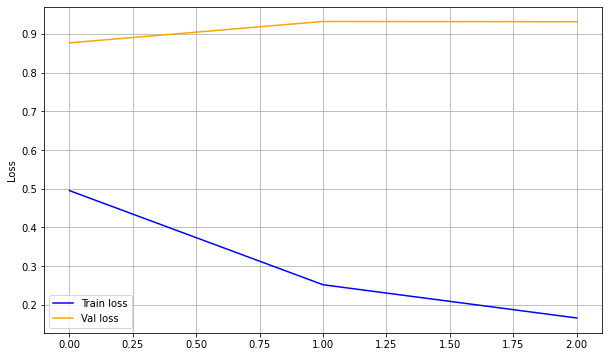

epoch_number is 3. Train


100%|██████████| 146/146 [04:18<00:00,  1.77s/it]


epoch_number is 3. Test


 88%|████████▊ | 7/8 [00:12<00:01,  1.78s/it]


KeyboardInterrupt: 

In [29]:
train_model(vgg16, num_epochs, loss_function, optimizer, scheduler, train_dataloader, test_dataloader)

Просмотр результатов обучения модели

In [30]:
vgg16.train(False)
torch.save(vgg16.state_dict(), 'vgg16.pth')

In [31]:
preds = []
real = []
for x, y in tqdm(test_dataloader):
    with torch.no_grad():
        preds.append(vgg16.forward(x.to(device)).detach().cpu().numpy())
        real.append(y.numpy())

100%|██████████| 8/8 [00:13<00:00,  1.66s/it]


In [32]:
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)

In [33]:
final_preds.min()

0

In [34]:
print(classification_report(real, final_preds))

              precision    recall  f1-score   support

           0       0.58      0.50      0.54        72
           1       0.61      0.61      0.61        98
           2       0.45      0.63      0.52       204
           3       0.42      0.48      0.45        23
           4       0.44      0.58      0.50       243
           5       0.92      0.81      0.86      1336
           6       0.79      0.70      0.75        27

    accuracy                           0.74      2003
   macro avg       0.60      0.62      0.60      2003
weighted avg       0.78      0.74      0.75      2003



### Реализуем собственную модель

Распишем собственную модель

In [5]:
class custom_model(nn.Module):
    def __init__(self, num_classes=7, img_size=32, in_channels=3, num_blocks=4):
        super(custom_model, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=8, padding=0),
            nn.Flatten(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Проверка работоспособности

In [37]:
custom_model().forward(torch.ones(3, 3, 32, 32)).shape

torch.Size([3, 7])

Обучения модели

In [41]:
my_model = custom_model().to(device)

In [42]:
all_train_losses = []
all_test_losses = []
num_epochs = 3
lr = 1e-3
optimizer2 = Adam(my_model.parameters(), lr=lr)
scheduler2 = ReduceLROnPlateau(optimizer=optimizer2, factor=0.5, patience=2, threshold=1e-3)

loss train 0.6893945291434251
loss test 1.0615056455135345


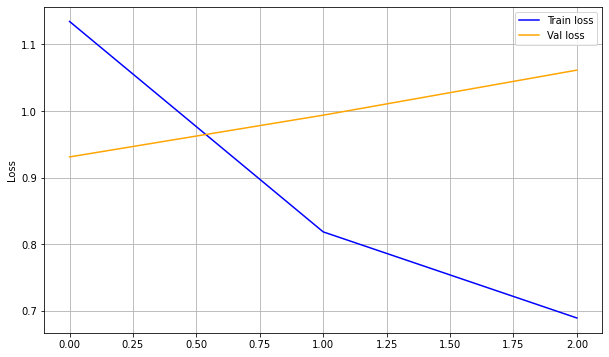

In [43]:
train_model(my_model, num_epochs, loss_function, optimizer2, scheduler2, train_dataloader, test_dataloader)

Видно переобучение уже на третьей эпохе

Получение результатов

In [44]:
preds = []
real = []
for x, y in tqdm(test_dataloader):
    with torch.no_grad():
        preds.append(my_model.forward(x.to(device)).detach().cpu().numpy())
        real.append(y.numpy())

100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


In [45]:
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)

In [46]:
print(classification_report(real, final_preds))

              precision    recall  f1-score   support

           0       0.28      0.32      0.30        72
           1       0.30      0.60      0.40        98
           2       0.34      0.55      0.42       204
           3       0.07      0.39      0.13        23
           4       0.37      0.45      0.41       243
           5       0.94      0.65      0.77      1336
           6       0.36      0.81      0.50        27

    accuracy                           0.60      2003
   macro avg       0.38      0.54      0.42      2003
weighted avg       0.74      0.60      0.64      2003



Видно, что модель работает хуже, чем vgg16

In [47]:
torch.save(my_model.state_dict(), 'my_model.pth')

### Попробуем дистиллировать знания из vgg в мою кастомную предобученную модель

Получим пердсказания всего обучающего набора данных на трейн части

In [54]:
train_dataset2 = CustomDataset(X_train, y_train, transform_probability_dict, train=False)
train_dataloader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=False, drop_last=False)
preds = []
real = []
for x, y in tqdm(train_dataloader2):
    with torch.no_grad():
        preds.append(vgg16.forward(x.to(device)).detach().cpu().numpy())
        real.append(y.numpy())

100%|██████████| 147/147 [03:52<00:00,  1.58s/it]


In [56]:
len(X_train)

37583

Сохраним все наборы данных, например для будущих дистилляций

In [57]:
np.save('distil.npy', np.concatenate(preds))

In [58]:
np.save('train_paths.npy', X_train)

In [59]:
np.save('test_paths.npy', X_test)

In [60]:
np.save('test_labels.npy', y_test)

Напишем собственный датасет, у которого в качестве выхода будут логиты vgg16

In [64]:
class CustomLogitsDataset(Dataset):
    def __init__(self, images_paths, image_labels, transform_probs, train=True):
        self.paths = images_paths
        self.labels = torch.tensor(image_labels)
        self.train = train
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, item):
        image_name = self.paths[item]
        image_label = torch.tensor(self.labels[item])
        image = Image.open(f'D:\mlp\MachineLearning\MADMO_2nd_homework\merged_data\{image_name}.jpg')
        transformation = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((32, 32)),
                transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5)
            ]
        )
        image = transformation(image)
        return image, image_label

Сделаем новый даталоадер для модели с логитами. В обучающую функцию надо передать также и тест даталоадер, поэтому была создана обычная заглушка, в которой почти нет данных

In [77]:
train_dataset_logits = CustomLogitsDataset(X_train,  np.concatenate(preds), transform_probability_dict, train=True)
train_dataloader_logits = DataLoader(train_dataset_logits, batch_size=batch_size, shuffle=True, drop_last=True)

dataset_zaglushka = CustomLogitsDataset(X_train[:3],  np.concatenate(preds)[:3], transform_probability_dict, train=True)
dataloader_zaglushka = DataLoader(dataset_zaglushka, batch_size=batch_size, shuffle=True, drop_last=True)

Распишем функцию потерь для дистилляции

In [78]:
def kl_loss_function(preds, true):
    softmax= nn.Softmax()
    loss = nn.KLDivLoss()
    return loss(softmax(preds), softmax(true))

Дистиллируем модель

loss train -0.11382891998103215
loss test 0


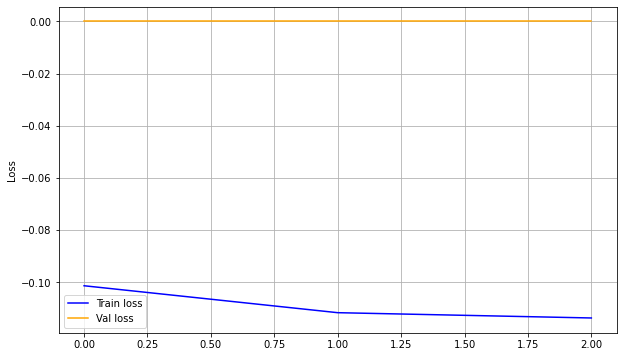

In [81]:
all_train_losses = []
all_test_losses = []
num_epochs = 3
lr = 1e-4
optimizer_distill = Adam(my_model.parameters(), lr=lr)
scheduler_distill = ReduceLROnPlateau(optimizer=optimizer_distill, factor=0.5, patience=2, threshold=1e-3)
train_model(my_model, num_epochs, kl_loss_function, optimizer_distill, scheduler_distill, train_dataloader_logits, dataloader_zaglushka)

Сохраним дистиллированную модель

In [82]:
torch.save(my_model.state_dict(), 'my_model_distilled.pth')

Посмотрим на результаты работы модели после дистиляции занний в нее

In [83]:
preds = []
real = []
for x, y in tqdm(test_dataloader):
    with torch.no_grad():
        preds.append(my_model.forward(x.to(device)).detach().cpu().numpy())
        real.append(y.numpy())
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)
print(classification_report(real, final_preds))

100%|██████████| 8/8 [00:11<00:00,  1.49s/it]

              precision    recall  f1-score   support

           0       0.28      0.44      0.34        72
           1       0.35      0.59      0.44        98
           2       0.41      0.55      0.47       204
           3       0.17      0.39      0.23        23
           4       0.31      0.57      0.40       243
           5       0.95      0.63      0.76      1336
           6       0.31      0.81      0.44        27

    accuracy                           0.60      2003
   macro avg       0.40      0.57      0.44      2003
weighted avg       0.75      0.60      0.64      2003



Видно, что модель стала работать лучше

### Прунинг модели

In [2]:
import torch.nn.utils.prune as prune

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
my_model = custom_model().to(device)

In [10]:
my_model.load_state_dict(torch.load('my_model_distilled.pth'))

<All keys matched successfully>

In [29]:
list(my_model.named_parameters())

[('network.0.weight',
  Parameter containing:
  tensor([[[[-1.6450e-01,  7.1729e-02,  3.8232e-02],
            [-8.1310e-02,  7.0938e-02,  1.3076e-01],
            [ 1.3661e-01, -1.3643e-02,  1.3898e-01]],
  
           [[-1.1527e-01, -9.0168e-02,  1.4220e-01],
            [-8.1381e-02, -1.0638e-01,  2.7900e-02],
            [-1.7061e-01, -1.5271e-01, -2.0872e-01]],
  
           [[ 7.7182e-02,  1.6336e-01, -5.3359e-02],
            [-5.8709e-02,  5.5510e-02, -1.7101e-02],
            [ 1.6496e-01,  8.4235e-02,  1.6009e-01]]],
  
  
          [[[ 3.1319e-02, -1.5807e-01,  1.4576e-02],
            [-7.8010e-03,  9.6179e-02,  1.4549e-01],
            [ 1.2192e-01, -1.8322e-01,  1.0095e-01]],
  
           [[ 1.4442e-01, -1.2513e-01,  1.6564e-01],
            [-9.0358e-02, -1.2560e-01,  1.1008e-01],
            [-4.2875e-02, -3.2928e-05, -7.4134e-02]],
  
           [[-5.3963e-02,  1.3545e-02, -2.0425e-02],
            [ 6.7547e-02, -1.2748e-01, -1.4219e-01],
            [ 2.0199e-01, -1.

In [30]:
list(my_model.network[0].named_parameters())

[('weight',
  Parameter containing:
  tensor([[[[-1.6450e-01,  7.1729e-02,  3.8232e-02],
            [-8.1310e-02,  7.0938e-02,  1.3076e-01],
            [ 1.3661e-01, -1.3643e-02,  1.3898e-01]],
  
           [[-1.1527e-01, -9.0168e-02,  1.4220e-01],
            [-8.1381e-02, -1.0638e-01,  2.7900e-02],
            [-1.7061e-01, -1.5271e-01, -2.0872e-01]],
  
           [[ 7.7182e-02,  1.6336e-01, -5.3359e-02],
            [-5.8709e-02,  5.5510e-02, -1.7101e-02],
            [ 1.6496e-01,  8.4235e-02,  1.6009e-01]]],
  
  
          [[[ 3.1319e-02, -1.5807e-01,  1.4576e-02],
            [-7.8010e-03,  9.6179e-02,  1.4549e-01],
            [ 1.2192e-01, -1.8322e-01,  1.0095e-01]],
  
           [[ 1.4442e-01, -1.2513e-01,  1.6564e-01],
            [-9.0358e-02, -1.2560e-01,  1.1008e-01],
            [-4.2875e-02, -3.2928e-05, -7.4134e-02]],
  
           [[-5.3963e-02,  1.3545e-02, -2.0425e-02],
            [ 6.7547e-02, -1.2748e-01, -1.4219e-01],
            [ 2.0199e-01, -1.0996e-01, 

In [31]:
prune.random_unstructured(my_model.network[0], name="weight", amount=0.3)

Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [32]:
list(my_model.network[0].named_parameters())

[('bias',
  Parameter containing:
  tensor([-0.0959, -0.0240,  0.0940,  0.1523,  0.0888, -0.1228,  0.1682,  0.1842],
         device='cuda:0', requires_grad=True)),
 ('weight_orig',
  Parameter containing:
  tensor([[[[-1.6450e-01,  7.1729e-02,  3.8232e-02],
            [-8.1310e-02,  7.0938e-02,  1.3076e-01],
            [ 1.3661e-01, -1.3643e-02,  1.3898e-01]],
  
           [[-1.1527e-01, -9.0168e-02,  1.4220e-01],
            [-8.1381e-02, -1.0638e-01,  2.7900e-02],
            [-1.7061e-01, -1.5271e-01, -2.0872e-01]],
  
           [[ 7.7182e-02,  1.6336e-01, -5.3359e-02],
            [-5.8709e-02,  5.5510e-02, -1.7101e-02],
            [ 1.6496e-01,  8.4235e-02,  1.6009e-01]]],
  
  
          [[[ 3.1319e-02, -1.5807e-01,  1.4576e-02],
            [-7.8010e-03,  9.6179e-02,  1.4549e-01],
            [ 1.2192e-01, -1.8322e-01,  1.0095e-01]],
  
           [[ 1.4442e-01, -1.2513e-01,  1.6564e-01],
            [-9.0358e-02, -1.2560e-01,  1.1008e-01],
            [-4.2875e-02, -3.292

In [33]:
print(list(my_model.network[0].named_buffers()))

[('weight_mask', tensor([[[[0., 1., 0.],
          [1., 1., 1.],
          [1., 1., 0.]],

         [[1., 1., 1.],
          [0., 1., 1.],
          [1., 1., 1.]],

         [[1., 0., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[1., 1., 0.],
          [1., 0., 1.],
          [1., 1., 0.]],

         [[1., 1., 0.],
          [1., 1., 1.],
          [1., 1., 0.]],

         [[0., 0., 0.],
          [1., 1., 1.],
          [0., 1., 0.]]],


        [[[1., 1., 0.],
          [0., 0., 0.],
          [1., 1., 1.]],

         [[1., 1., 0.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 0., 1.],
          [1., 0., 1.]]],


        [[[1., 1., 1.],
          [0., 1., 1.],
          [1., 1., 1.]],

         [[1., 0., 0.],
          [1., 0., 0.],
          [1., 1., 1.]],

         [[0., 0., 1.],
          [0., 1., 1.],
          [1., 0., 1.]]],


        [[[0., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1.

Первый сверточный слой модуля network запрунен. Выше видно маску весов